In [12]:
# Cell 1: Imports and setup

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import chi2_contingency
from itertools import combinations
from pathlib import Path

# Paths
cwd = Path.cwd()
masterlistpath = cwd / "experiment1_taskfreelymovingspecificity.csv"
savepath = cwd / "Figure4DE"
savepath.mkdir(exist_ok=True)

# Load masterlist
masterlist = np.loadtxt(masterlistpath, delimiter=',', dtype=str)

areas = ['LA', 'BLA', 'PIR']
neuroncount = np.zeros((len(areas), 3))

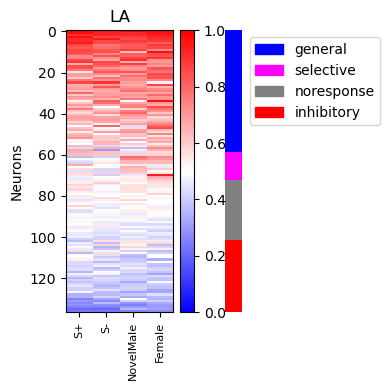

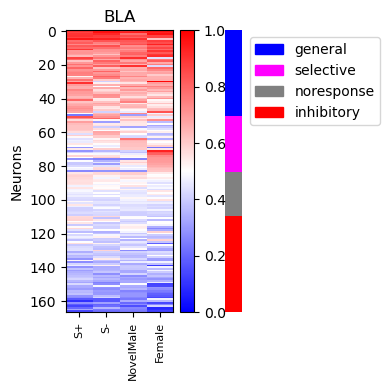

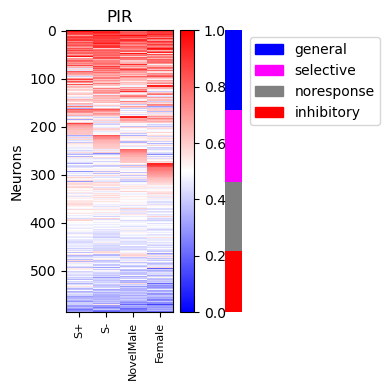

In [13]:
# Cell 2: Generate heatmaps per area

for area in areas:
    rows = masterlist[masterlist[:,2] == area]

    general = rows[rows[:,-1] == '1.0']
    taskselective = rows[rows[:,-1] == '-1.0']
    nontaskselective = rows[rows[:,-1] == '-2.0']
    inhibitory = rows[rows[:,-1] == '-3.0']

    other = rows[rows[:,-1] == '0.0']

    generalroc = general[:, -5:-1].astype(float)
    taskselectiveroc = taskselective[:, -5:-1].astype(float)
    nontaskselectiveroc = nontaskselective[:, -5:-1].astype(float)
    inhibitoryroc = inhibitory[:, -5:-1].astype(float)
    otherroc = other[:, -5:-1].astype(float)

    sortorder = np.argsort(np.mean(generalroc, axis=1))
    generalroc = np.flip(generalroc[sortorder], axis=0)
    multitaskselective = taskselectiveroc[np.where((taskselectiveroc[:,:2] > 0.6).all(axis=1))[0]]
    sortorder = np.argsort(np.mean(multitaskselective[:,:2], axis=1))
    multitaskselective = np.flip(multitaskselective[sortorder], axis=0)

    rewardselective = taskselectiveroc[np.where((taskselectiveroc[:,0] > 0.6) & (taskselectiveroc[:,1] < 0.6))[0]]
    sortorder = np.argsort(rewardselective[:,0])
    rewardselective = np.flip(rewardselective[sortorder], axis=0)

    unrewardselective = taskselectiveroc[np.where((taskselectiveroc[:,0] < 0.6) & (taskselectiveroc[:,1] > 0.6))[0]]
    sortorder = np.argsort(unrewardselective[:,1])
    unrewardselective = np.flip(unrewardselective[sortorder], axis=0)

    multinontaskselective = nontaskselectiveroc[np.where((nontaskselectiveroc[:,2:] > 0.6).all(axis=1))[0]]
    sortorder = np.argsort(np.mean(multinontaskselective[:,2:], axis=1))
    multinontaskselective = np.flip(multinontaskselective[sortorder], axis=0)

    novelmaleselective = nontaskselectiveroc[np.where((nontaskselectiveroc[:,2] > 0.6) & (nontaskselectiveroc[:,3] < 0.6))[0]]
    sortorder = np.argsort(novelmaleselective[:,2])
    novelmaleselective = np.flip(novelmaleselective[sortorder], axis=0)

    femaleselective = nontaskselectiveroc[np.where((nontaskselectiveroc[:,2] < 0.6) & (nontaskselectiveroc[:,3] > 0.6))[0]]
    sortorder = np.argsort(femaleselective[:,3])
    femaleselective = np.flip(femaleselective[sortorder], axis=0)

    selectiveroc = np.vstack((multitaskselective, multinontaskselective,
                              rewardselective, unrewardselective,
                              novelmaleselective, femaleselective))

    sortorder = np.argsort(np.mean(otherroc, axis=1))
    otherroc = np.flip(otherroc[sortorder], axis=0)
    sortorder = np.argsort(np.mean(inhibitoryroc, axis=1))
    inhibitoryroc = np.flip(inhibitoryroc[sortorder], axis=0)

    allresponses = np.vstack((generalroc, selectiveroc, otherroc, inhibitoryroc))



    # Define color map for neuronal categories
    color_map = {'general': 'blue', 'selective': 'magenta', 'noresponse': 'gray', 'inhibitory': 'red'}

    # Create an array of colors for each neuron
    neuron_colors = np.concatenate([np.repeat(color_map['general'], len(generalroc)),
                                    np.repeat(color_map['selective'], len(selectiveroc)),
                                    np.repeat(color_map['noresponse'], len(otherroc)),
                                    np.repeat(color_map['inhibitory'], len(inhibitoryroc))])
    # Plot heatmap + colorbar column
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 4), gridspec_kw={'width_ratios': [15, 2]})
    im = ax1.imshow(allresponses, aspect='auto', vmin=0, vmax=1, cmap='bwr', interpolation='None')
    ax1.set_xticks([0, 1, 2, 3]); ax1.set_xticklabels(['S+', 'S-', 'NovelMale', 'Female'], fontsize=8, rotation=90)
    ax1.set_title(area); ax1.set_ylabel('Neurons')

    # Plot the color-coded column in the second subplot
    ax2.barh(np.arange(len(neuron_colors)), np.ones(len(neuron_colors)), color=neuron_colors, edgecolor='none', height=1.1)
    ax2.set_ylim(ax1.get_ylim())  # Align the y-axis limits with the heatmap
    ax2.set_yticks([])  # Remove y-axis ticks
    ax2.set_xticks([])  # Remove x-axis ticks
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # Create a legend for the color-coded column
    handles = [mpatches.Patch(color=color_map[category], label=category) for category in color_map]
    ax2.legend(handles=handles, bbox_to_anchor=(1,1))

    plt.colorbar(im)
    plt.tight_layout()
    plt.show()
    fig.savefig(savepath / f"{area}_heatmapFMtaskneurons.png", format="png")
    plt.close()

    neuroncount[areas.index(area), 0] = selectiveroc.shape[0]
    neuroncount[areas.index(area), 1] = generalroc.shape[0]
    neuroncount[areas.index(area), 2] = allresponses.shape[0]


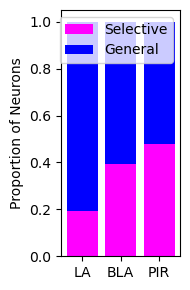

In [14]:
# Cell 3: Compare proportions of selective vs general neurons

fig, ax = plt.subplots(1, 1, figsize=(2, 3))
ax.bar(np.arange(len(areas)), neuroncount[:, 0] / np.sum(neuroncount[:, :2], axis=1),
       color='magenta', label='Selective')
ax.bar(np.arange(len(areas)), neuroncount[:, 1] / np.sum(neuroncount[:, :2], axis=1),
       color='blue', bottom=neuroncount[:, 0] / np.sum(neuroncount[:, :2], axis=1), label='General')
ax.set_xticks(np.arange(len(areas))); ax.set_xticklabels(areas)
ax.set_ylabel('Proportion of Neurons'); ax.legend()
plt.tight_layout()
plt.show()
plt.savefig(savepath / "selective_vs_general.png", format="png")
plt.close()


In [15]:
# Cell 4: Chi-square tests per area

areas_test = ['LA', 'BLA', 'PIR']
results = []

for (i, j) in combinations(range(len(areas_test)), 2):
    contingency_table = neuroncount[[i, j], :2]
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results.append((areas_test[i], areas_test[j], chi2, p))

# Bonferroni correction
alpha = 0.05 / len(results)
for area1, area2, chi2, p in results:
    if p < alpha:
        print(f"Comparison {area1} vs {area2}: χ²={chi2:.3f}, p={p:.3g} (significant)")


Comparison LA vs BLA: χ²=6.601, p=0.0102 (significant)
Comparison LA vs PIR: χ²=18.714, p=1.52e-05 (significant)
